
<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Project-Phase1<br>
    Image Segmentation<br>
<font color=696880 size=4>
    Shayan Baghayi Nejad-Armin Khosravi


<font size=5 color=cyan> Names:Parsa Mohammad Hasazadeh - Ali mirzaei feizabadi

Student Numbers:  </font> 402106423 - 402106672

# Introduction

In this Project, we will become familiar with UNet architecture, Attention mechanism, and Residual blocks with the help of which we will build UNet, AttentionUNet, and ResidualAttentionUnet from scratch using PyTorch framework. The built models will be evaluated by various metrics such as accuracy, Iou score, and Dice score.

### Environment Setup

Here you will find the required packages. Feel free to add the list.

In [1]:
import os
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import kagglehub
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Hyperparameter Setting

Place your hyperparameters' values in the cell below.

In [16]:
DATA_DIR = "/content/drive/MyDrive/massachusetts-roads-dataset"        # path where dataset is stored
IMAGE_SIZE = (128, 128)    # resize images to this size (height, width)
BATCH_SIZE = 16            # number of images per batch
NUM_WORKERS = 4            # number of CPU workers for data loading
LR = 1e-4                  # learning rate for Adam optimizer
NUM_EPOCHS = 50            # number of training epochs


# Data Preparation

Our task is to segment the [Massachusetts Road Dataset](https://www.kaggle.com/datasets/balraj98/massachusetts-roads-dataset). You can download this dataset by placing your API Token from kaggle in ```~/.kaggle/``` folder (Instructions can be found in the Kaggle website) and then running the code below.

In [17]:
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/massachusetts-roads-dataset


\If you are running on colab, it is highly recommended to save the dataset to your drive to avoid problems when disconnecting from runtime.

In [18]:
from google.colab import drive

drive.mount('/content/drive')

shutil.move(path, '/content/drive/MyDrive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Error: Destination path '/content/drive/MyDrive/massachusetts-roads-dataset' already exists

### Loading Images

Load the images and their corresponding masks in two separate lists. (The cell below might take some time to execute.)

In [20]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def load_images_and_masks(images_path, masks_path, image_size):
    """
    Loads and preprocesses images and their corresponding masks.
    Returns numpy arrays. Skips unreadable/corrupted pairs safely.
    """
    valid_ext = (".tif", ".tiff", ".png", ".jpg", ".jpeg", ".bmp")

    image_files = sorted([f for f in os.listdir(images_path) if f.lower().endswith(valid_ext)])
    mask_files  = sorted([f for f in os.listdir(masks_path)  if f.lower().endswith(valid_ext)])

    images, masks = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path  = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path,  mask_file)
        try:
            img  = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            img  = img.resize(image_size)
            mask = mask.resize(image_size)

            img  = np.asarray(img,  dtype=np.float32) / 255.0
            mask = np.asarray(mask, dtype=np.float32) / 255.0

            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"[WARN] Skipping pair ({img_file}, {mask_file}): {e}")

    return np.array(images), np.array(masks)


train_images_dir = os.path.join(DATA_DIR, 'tiff/train')
train_masks_dir = os.path.join(DATA_DIR, 'tiff/train_labels')

train_images_path = train_images_dir
train_masks_path = train_masks_dir

train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path, IMAGE_SIZE)

val_images_dir = os.path.join(DATA_DIR, 'tiff/val')
val_masks_dir = os.path.join(DATA_DIR, 'tiff/val_labels')

val_images_path = val_images_dir
val_masks_path = val_masks_dir

val_images, val_masks = load_images_and_masks(val_images_path, val_masks_path, IMAGE_SIZE)


### Data Visualization

Display the images and their masks for several samples.

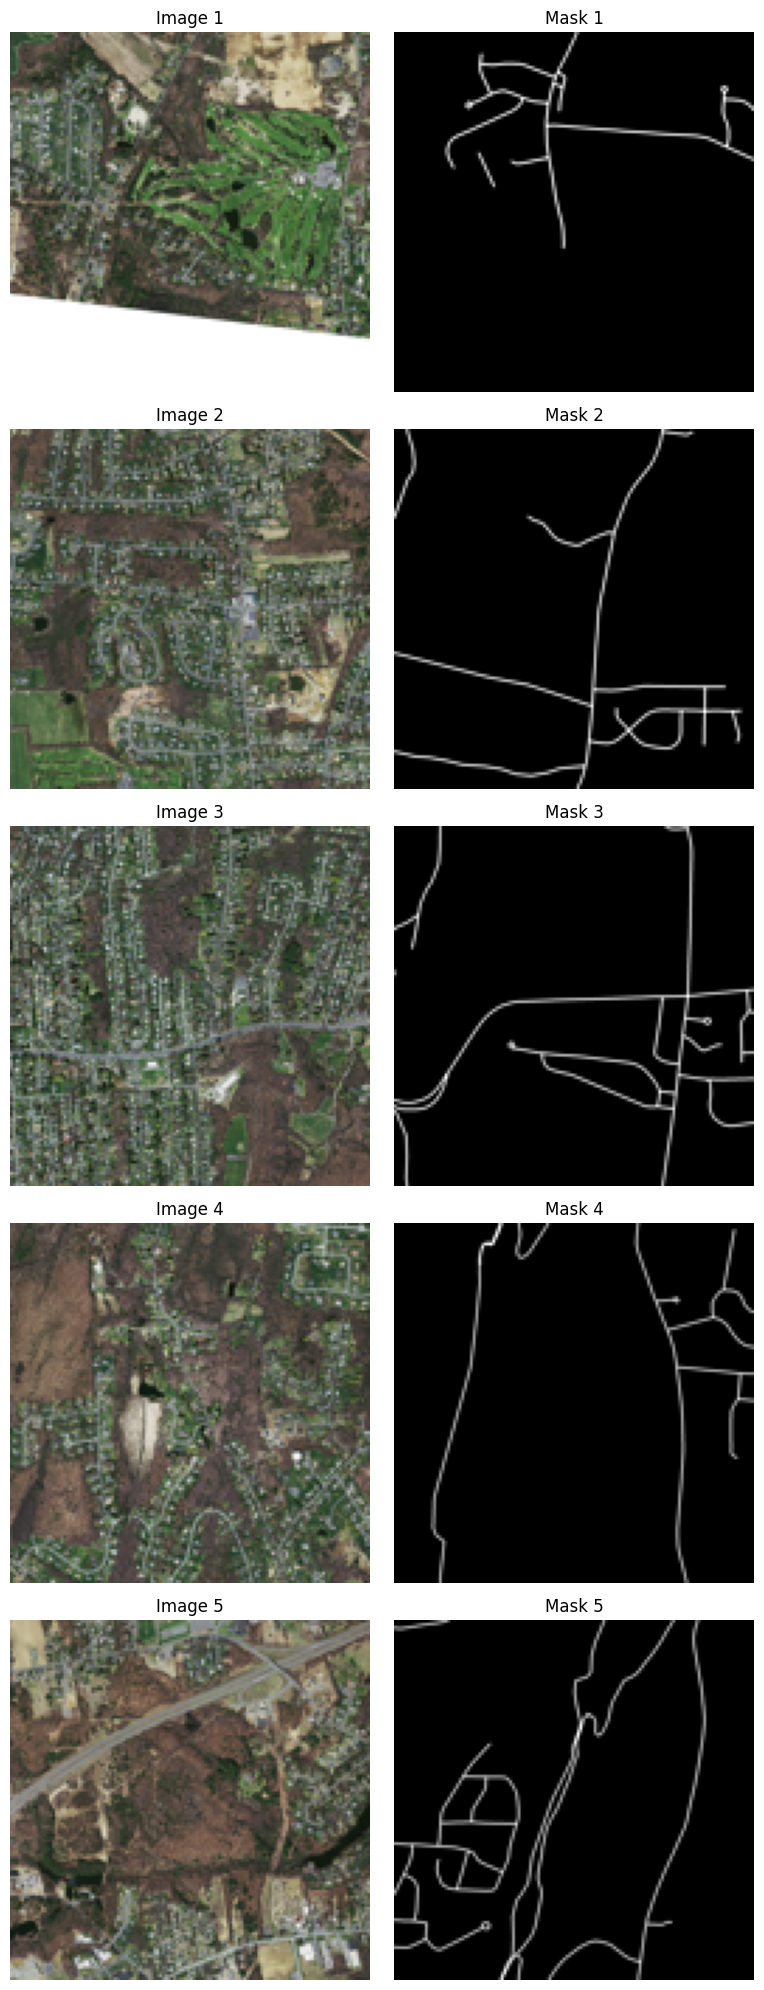

In [21]:
%matplotlib inline

def visualize_images_and_masks(images, masks, n=5):
    """
    Visualizes 'n' images and their corresponding masks side by side.

    Args:
        images (array-like): Collection of input images (NumPy arrays or PyTorch tensors).
        masks (array-like):  Collection of corresponding mask images (NumPy arrays or PyTorch tensors).
        n (int): Number of image-mask pairs to display.
    """
    if images is None or masks is None or len(images) == 0 or len(masks) == 0:
        print("Nothing to show: images or masks are empty.")
        return

    max_n = min(n, len(images), len(masks))

    import numpy as _np
    import torch as _torch

    plt.figure(figsize=(8, 4 * max_n))
    for i in range(max_n):
        img = images[i]
        msk = masks[i]

        if isinstance(img, _torch.Tensor):
            img = img.detach().cpu().numpy()
        if isinstance(msk, _torch.Tensor):
            msk = msk.detach().cpu().numpy()

        if isinstance(img, _np.ndarray) and img.ndim == 3 and img.shape[0] in (1, 3):
            img = _np.transpose(img, (1, 2, 0))

        if isinstance(msk, _np.ndarray) and msk.ndim == 3:
            if msk.shape[-1] == 1:
                msk = _np.squeeze(msk, axis=-1)
            else:
                msk = _np.squeeze(msk, axis=0)

        if isinstance(img, _np.ndarray):
            img = _np.clip(img, 0, 1)
        if isinstance(msk, _np.ndarray):
            msk = _np.clip(msk, 0, 1)

        plt.subplot(max_n, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(max_n, 2, 2 * i + 2)
        plt.imshow(msk, cmap="gray")
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_images_and_masks(train_images, train_masks, n=5)


### Dataset Creation

Finally, we will make the dataset using the list of images we have stored.

In [22]:
class RoadDataset(Dataset):
    """
    Custom Dataset class for loading road images and their corresponding masks.

    Args:
        images (array-like): List or array of input images.
        masks (array-like): List or array of corresponding masks.
        image_transform (callable, optional): Transformation to apply to the images.
        mask_transform (callable, optional): Transformation to apply to the masks.
    """
    def __init__(self, images, masks, image_transform=None, mask_transform=None):
        self.images = images
        self.masks = masks
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        image = Image.fromarray((image * 255).astype(np.uint8)) if isinstance(image, np.ndarray) else image
        mask  = Image.fromarray((mask  * 255).astype(np.uint8)) if isinstance(mask,  np.ndarray) else mask

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask


image_transform = transforms.Compose([
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = RoadDataset(train_images, train_masks, image_transform, mask_transform)
val_dataset   = RoadDataset(val_images, val_masks, image_transform, mask_transform)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# UNet

Before proceeding, it is necessary to understand the idea behind UNet. In order to avoid too much details in this notebook, you can read the complete paper for UNet from [this link](https://arxiv.org/pdf/1505.04597).

The overall structure of UNet is provided in the image below.

![UNet Architecture](https://viso.ai/wp-content/uploads/2024/04/unet-process.png)

### Convolution Block

Convolution block is used at each level of UNet.

In [23]:
class ConvBlock(nn.Module):
    """
    A convolutional block consisting of multiple layers (e.g., Conv2D, BatchNorm, ReLU).

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


### Up Convoluitional Block

We use another block to upsample the latent vector.

In [24]:
class UpConvBlock(nn.Module):
    """
    An upsampling block used in decoder parts of segmentation networks like U-Net.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upconv(x)


### Complete UNet Structure

Now using the ```ConvBlock``` and ```UpConvBlock``` you created, complete the UNet architecture.

In [25]:
class UNet(nn.Module):
    """
    U-Net architecture for image segmentation tasks.

    Args:
        in_channel (int): Number of input channels (e.g., 3 for RGB images).
        out_channel (int): Number of output channels (e.g., 1 for binary segmentation).
        filter (list): List of filter sizes for each level of the encoder/decoder.
    """
    def __init__(self, in_channel=3, out_channel=1, filter=[64, 128, 256, 512]):
        super().__init__()

        f = filter

        self.enc1 = ConvBlock(in_channel, f[0])
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ConvBlock(f[0], f[1])
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ConvBlock(f[1], f[2])
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ConvBlock(f[2], f[3])
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ConvBlock(f[3], f[3] * 2)

        self.up4 = UpConvBlock(f[3] * 2, f[3])
        self.dec4 = ConvBlock(f[3] * 2, f[3])

        self.up3 = UpConvBlock(f[3], f[2])
        self.dec3 = ConvBlock(f[2] * 2, f[2])

        self.up2 = UpConvBlock(f[2], f[1])
        self.dec2 = ConvBlock(f[1] * 2, f[1])

        self.up1 = UpConvBlock(f[1], f[0])
        self.dec1 = ConvBlock(f[0] * 2, f[0])

        self.out_conv = nn.Conv2d(f[0], out_channel, kernel_size=1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        p4 = self.pool4(x4)

        x5 = self.bottleneck(p4)

        d4 = self.up4(x5)
        d4 = torch.cat([x4, d4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([x3, d3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([x2, d2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([x1, d1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return self.activation(out)


# Attention UNet

### Attention Mechanism

Attention UNet uses this mechanism to know what part the image is more important to attend to. You can read about this mechanism from [this link](https://arxiv.org/pdf/1706.03762). The Attention mechanism in UNet is described in [this paper](https://arxiv.org/pdf/1804.03999).


![Attention](https://www.researchgate.net/publication/373655981/figure/fig3/AS:11431281186315360@1693879045519/Visualization-of-attention-blocks-reveals-their-functionality-While-the-self-attention.png)

In [26]:
class AttentionBlock(nn.Module):
    """
    Attention block for focusing on relevant features in skip connections.

    Args:
        f_g (int): Number of channels in the gating signal (from decoder).
        f_l (int): Number of channels in the skip connection input (from encoder).
        f_int (int): Number of intermediate channels used within the attention block.
    """
    def __init__(self, f_g, f_l, f_int):
        super().__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(f_g, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.w_x = nn.Sequential(
            nn.Conv2d(f_l, f_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(f_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(f_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.act = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        g: gating signal from decoder (coarser)
        x: skip connection from encoder (finer)
        """
        g1 = self.w_g(g)
        x1 = self.w_x(x)

        if g1.shape[2:] != x1.shape[2:]:
            g1 = nn.functional.interpolate(g1, size=x1.shape[2:], mode="bilinear", align_corners=False)

        psi = self.act(g1 + x1)
        psi = self.psi(psi)

        return x * psi


Now use the ```AttentionBlock``` to inherit [Attention UNet](https://arxiv.org/pdf/1804.03999) from UNet.

![Attention UNet](https://www.researchgate.net/publication/347344899/figure/fig6/AS:971357475069952@1608601077414/The-architecture-of-Attention-U-Net-Attention-gate-selects-features-by-using-the.png)

In [27]:
class AttentionUNet(UNet):
    """
    Attention U-Net architecture which extends the basic U-Net
    by integrating attention blocks in the skip connections.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        f = filter_sizes
        self.att4 = AttentionBlock(f_g=f[3], f_l=f[3], f_int=f[3] // 2)
        self.att3 = AttentionBlock(f_g=f[2], f_l=f[2], f_int=f[2] // 2)
        self.att2 = AttentionBlock(f_g=f[1], f_l=f[1], f_int=f[1] // 2)
        self.att1 = AttentionBlock(f_g=f[0], f_l=f[0], f_int=f[0] // 2)

    def forward(self, x):
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        p4 = self.pool4(x4)

        x5 = self.bottleneck(p4)

        d4 = self.up4(x5)
        x4_att = self.att4(d4, x4)
        d4 = torch.cat([x4_att, d4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        x3_att = self.att3(d3, x3)
        d3 = torch.cat([x3_att, d3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        x2_att = self.att2(d2, x2)
        d2 = torch.cat([x2_att, d2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        x1_att = self.att1(d1, x1)
        d1 = torch.cat([x1_att, d1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return self.activation(out)


# Residual Attention UNet

We will add residual blocks to the attention for better gradient flow. You can read more about residual blocks [here](https://arxiv.org/pdf/1512.03385).

<img src="https://dfzljdn9uc3pi.cloudfront.net/2023/cs-1302/1/fig-1-full.png" width="400" alt="ResUNet Architecture">

In [28]:
class ResidualConvBlock(nn.Module):
    """
    Residual convolutional block with skip connection.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
    """
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channel)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channel)
        ) if in_channel != out_channel else nn.Identity()

        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out + (self.shortcut(x) if not isinstance(self.shortcut, nn.Identity) else x)
        return self.act(out)


Use ```ResidualConvBlock``` to construct Residual Attention Unet.

In [29]:
class ResidualAttentionUNet(AttentionUNet):
    """
    Residual Attention U-Net combining residual blocks with attention mechanisms.

    Args:
        in_channel (int): Number of input channels.
        out_channel (int): Number of output channels.
        filter_sizes (list): List of filter sizes for each level.
    """
    def __init__(self, in_channel=3, out_channel=1, filter_sizes=[64, 128, 256, 512]):
        super().__init__(in_channel, out_channel, filter_sizes)

        f = filter_sizes

        self.enc1 = ResidualConvBlock(in_channel, f[0])
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = ResidualConvBlock(f[0], f[1])
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = ResidualConvBlock(f[1], f[2])
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = ResidualConvBlock(f[2], f[3])
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = ResidualConvBlock(f[3], f[3] * 2)

        self.up4 = UpConvBlock(f[3] * 2, f[3])
        self.att4 = AttentionBlock(f_g=f[3], f_l=f[3], f_int=f[3] // 2)
        self.dec4 = ResidualConvBlock(f[3] * 2, f[3])

        self.up3 = UpConvBlock(f[3], f[2])
        self.att3 = AttentionBlock(f_g=f[2], f_l=f[2], f_int=f[2] // 2)
        self.dec3 = ResidualConvBlock(f[2] * 2, f[2])

        self.up2 = UpConvBlock(f[2], f[1])
        self.att2 = AttentionBlock(f_g=f[1], f_l=f[1], f_int=f[1] // 2)
        self.dec2 = ResidualConvBlock(f[1] * 2, f[1])

        self.up1 = UpConvBlock(f[1], f[0])
        self.att1 = AttentionBlock(f_g=f[0], f_l=f[0], f_int=f[0] // 2)
        self.dec1 = ResidualConvBlock(f[0] * 2, f[0])

    def forward(self, x):
        x1 = self.enc1(x)
        p1 = self.pool1(x1)

        x2 = self.enc2(p1)
        p2 = self.pool2(x2)

        x3 = self.enc3(p2)
        p3 = self.pool3(x3)

        x4 = self.enc4(p3)
        p4 = self.pool4(x4)

        x5 = self.bottleneck(p4)

        d4 = self.up4(x5)
        x4_att = self.att4(d4, x4)
        d4 = torch.cat([x4_att, d4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        x3_att = self.att3(d3, x3)
        d3 = torch.cat([x3_att, d3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        x2_att = self.att2(d2, x2)
        d2 = torch.cat([x2_att, d2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        x1_att = self.att1(d1, x1)
        d1 = torch.cat([x1_att, d1], dim=1)
        d1 = self.dec1(d1)

        out = self.out_conv(d1)
        return self.activation(out)


# Training

Now it is time to train the model on training data.

### Loss Function

We will be using the sum of [Dice Score](https://oecd.ai/en/catalogue/metrics/dice-score#:~:text=The%20Dice%20score%20is%20calculated,sizes%20of%20the%20two%20sets.), [Iou Score](https://www.v7labs.com/blog/intersection-over-union-guide), and Binary Cross Entropy as loss function. You can read about the mentioned scores in the provided links.

<font color=cyan><b> Note: Do Not Change The ```OverallLoss``` Function as it is used for measuring you model's performance.</b></font>

In [30]:
class DiceLoss(nn.Module):
    """
    Dice Loss for measuring overlap between predicted and ground truth masks.
    Particularly useful for imbalanced classes in segmentation tasks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)

        intersection = (pred * real).sum()
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + real.sum() + self.smooth)

        return 1 - dice_coeff


class IouLoss(nn.Module):
    """
    Intersection over Union (IoU) Loss for segmentation evaluation.
    Measures the overlap between predicted and ground truth masks.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(IouLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, real):
        pred = pred.view(-1)
        real = real.view(-1)

        intersection = (pred * real).sum()
        total = (pred + real).sum()
        union = total - intersection

        iou_coeff = (intersection + self.smooth) / (union + self.smooth)

        return 1 - iou_coeff


class OverallLoss(nn.Module):
    """
    Combined loss function that sums Dice loss, IoU loss, and Binary Cross-Entropy loss.

    Args:
        smooth (float): Small constant to avoid division by zero.
    """
    def __init__(self, smooth=1e-6):
        super(OverallLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.iou_loss = IouLoss(smooth)
        self.bce_loss = nn.BCELoss()

    def forward(self, pred, real):
        dice = self.dice_loss(pred, real)
        iou = self.iou_loss(pred, real)
        bce = self.bce_loss(pred, real)

        return dice, iou, bce, dice+iou+bce


### Training Epoch

Complete the function below to train the model for one epoch.

In [31]:
def train_one_epoch(model, optimizer, criterion, data_loader, scheduler=None, device='cuda'):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The neural network model to train.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (nn.Module): Loss function to compute the loss.
        data_loader (DataLoader): DataLoader providing training batches.
        scheduler (optional): Learning rate scheduler.
        device (str): Device to run the training on ('cuda' or 'cpu').

    Returns:
        float: Average loss over the epoch.
    """

    total_loss = 0.0
    model.train()

    for i, (img, mask) in enumerate(tqdm(data_loader)):
        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()

        pred = model(img)

        _, _, _, loss = criterion(pred, mask)

        loss.backward()

        optimizer.step()

        if scheduler:
            scheduler.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


Design a function for evaluation after each training phase.

In [32]:
def evaluate_model(model, criterion, data_loader, device='cuda'):
    """
    Evaluates the model on validation or test data.

    Args:
        model (nn.Module): The neural network model to evaluate.
        criterion (nn.Module): Loss function to compute evaluation metrics.
        data_loader (DataLoader): DataLoader providing evaluation batches.
        device (str): Device to run evaluation on ('cuda' or 'cpu').

    Returns:
        tuple: Average loss, average IoU score, and average Dice score over the dataset.
    """
    total_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0
    model.eval()

    with torch.no_grad():
        for i, (img, mask) in enumerate(tqdm(data_loader)):
            img = img.to(device)
            mask = mask.to(device)

            pred = model(img)

            dice_loss, iou_loss, bce_loss, overall_loss = criterion(pred, mask)

            total_loss += overall_loss.item()
            iou_score += 1 - iou_loss.item()
            dice_score += 1 - dice_loss.item()

        total_loss /= len(data_loader)
        iou_score /= len(data_loader)
        dice_score /= len(data_loader)

    return total_loss, iou_score, dice_score


# Model Training

### UNet  
Create an instance of UNet and train it. Then report the results.  

<b><font color=red>Note: your models need to satisfy below conditions to get complete score.</font></b>

<table style="width: 100%; font-size: 18px; border-collapse: collapse; margin: 15px 0;">
  <tr>
    <th style="text-align: left; padding: 8px; border-bottom: 2px solid #ddd;">Model</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Validation Loss</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Iou Score</th>
    <th style="text-align: right; padding: 8px; border-bottom: 2px solid #ddd;">Dice Score</th>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 1.0</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.5</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
  </tr>
  <tr>
    <td style="padding: 8px; border-bottom: 1px solid #ddd;">Attention UNet</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&lt; 0.9</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.6</td>
    <td style="text-align: right; padding: 8px; border-bottom: 1px solid #ddd;">&gt; 0.65</td>
  </tr>
  <tr>
    <td style="padding: 8px;">Residual Attention UNet</td>
    <td style="text-align: right; padding: 8px;">&lt; 0.8</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.65</td>
    <td style="text-align: right; padding: 8px;">&gt; 0.7</td>
  </tr>
</table>

In [33]:
unet = UNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(unet.parameters(), lr=LR)
# Add a scheduler if you like

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(unet.state_dict(), "best_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Iteration 1/50: Train Loss: 2.46 | Val Loss: 2.51 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Iteration 2/50: Train Loss: 2.40 | Val Loss: 2.46 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Iteration 3/50: Train Loss: 2.35 | Val Loss: 2.38 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


Iteration 4/50: Train Loss: 2.31 | Val Loss: 2.29 | Iou Score: 0.07 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Iteration 5/50: Train Loss: 2.29 | Val Loss: 2.24 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Iteration 6/50: Train Loss: 2.27 | Val Loss: 2.22 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Iteration 7/50: Train Loss: 2.26 | Val Loss: 2.24 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Iteration 8/50: Train Loss: 2.24 | Val Loss: 2.31 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


Iteration 9/50: Train Loss: 2.22 | Val Loss: 2.19 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Iteration 10/50: Train Loss: 2.21 | Val Loss: 2.19 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Iteration 11/50: Train Loss: 2.20 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Iteration 12/50: Train Loss: 2.20 | Val Loss: 2.18 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Iteration 13/50: Train Loss: 2.19 | Val Loss: 2.18 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Iteration 14/50: Train Loss: 2.19 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


Iteration 15/50: Train Loss: 2.18 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Iteration 16/50: Train Loss: 2.18 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Iteration 17/50: Train Loss: 2.18 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Iteration 18/50: Train Loss: 2.17 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


Iteration 19/50: Train Loss: 2.17 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Iteration 20/50: Train Loss: 2.17 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Iteration 21/50: Train Loss: 2.17 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.50it/s]


Iteration 22/50: Train Loss: 2.16 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Iteration 23/50: Train Loss: 2.16 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Iteration 24/50: Train Loss: 2.16 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Iteration 25/50: Train Loss: 2.16 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Iteration 26/50: Train Loss: 2.16 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Iteration 27/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Iteration 28/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Iteration 29/50: Train Loss: 2.15 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Iteration 30/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Iteration 31/50: Train Loss: 2.15 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Iteration 32/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Iteration 33/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


Iteration 34/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Iteration 35/50: Train Loss: 2.14 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Iteration 36/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Iteration 37/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


Iteration 38/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Iteration 39/50: Train Loss: 2.14 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


Iteration 40/50: Train Loss: 2.13 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Iteration 41/50: Train Loss: 2.13 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


Iteration 42/50: Train Loss: 2.13 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Iteration 43/50: Train Loss: 2.13 | Val Loss: 2.12 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Iteration 44/50: Train Loss: 2.12 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


Iteration 45/50: Train Loss: 2.13 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  4.39it/s]


Iteration 46/50: Train Loss: 2.12 | Val Loss: 2.12 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Iteration 47/50: Train Loss: 2.12 | Val Loss: 2.15 | Iou Score: 0.07 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Iteration 48/50: Train Loss: 2.12 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


Iteration 49/50: Train Loss: 2.11 | Val Loss: 2.12 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

Iteration 50/50: Train Loss: 2.11 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.09


Now do the same for Attention UNet and Reidual Attention UNet.

In [34]:
attention_unet = AttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(attention_unet.parameters(), lr=LR)

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(attention_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(attention_unet, criterion, val_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(attention_unet.state_dict(), "best_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Iteration 1/50: Train Loss: 2.46 | Val Loss: 2.45 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Iteration 2/50: Train Loss: 2.35 | Val Loss: 2.42 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


Iteration 3/50: Train Loss: 2.29 | Val Loss: 2.33 | Iou Score: 0.07 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Iteration 4/50: Train Loss: 2.25 | Val Loss: 2.24 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Iteration 5/50: Train Loss: 2.23 | Val Loss: 2.21 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Iteration 6/50: Train Loss: 2.22 | Val Loss: 2.18 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


Iteration 7/50: Train Loss: 2.21 | Val Loss: 2.18 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Iteration 8/50: Train Loss: 2.20 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Iteration 9/50: Train Loss: 2.19 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Iteration 10/50: Train Loss: 2.19 | Val Loss: 2.17 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Iteration 11/50: Train Loss: 2.18 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


Iteration 12/50: Train Loss: 2.18 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Iteration 13/50: Train Loss: 2.18 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Iteration 14/50: Train Loss: 2.17 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Iteration 15/50: Train Loss: 2.17 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Iteration 16/50: Train Loss: 2.17 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


Iteration 17/50: Train Loss: 2.17 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Iteration 18/50: Train Loss: 2.16 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Iteration 19/50: Train Loss: 2.16 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Iteration 20/50: Train Loss: 2.16 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Iteration 21/50: Train Loss: 2.16 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Iteration 22/50: Train Loss: 2.15 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Iteration 23/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Iteration 24/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


Iteration 25/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Iteration 26/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Iteration 27/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Iteration 28/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Iteration 29/50: Train Loss: 2.14 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


Iteration 30/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Iteration 31/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Iteration 32/50: Train Loss: 2.13 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Iteration 33/50: Train Loss: 2.13 | Val Loss: 2.20 | Iou Score: 0.07 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Iteration 34/50: Train Loss: 2.13 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


Iteration 35/50: Train Loss: 2.13 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Iteration 36/50: Train Loss: 2.13 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


Iteration 37/50: Train Loss: 2.12 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  4.66it/s]


Iteration 38/50: Train Loss: 2.11 | Val Loss: 2.12 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Iteration 39/50: Train Loss: 2.11 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Iteration 40/50: Train Loss: 2.11 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Iteration 41/50: Train Loss: 2.11 | Val Loss: 2.25 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Iteration 42/50: Train Loss: 2.10 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Iteration 43/50: Train Loss: 2.09 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Iteration 44/50: Train Loss: 2.08 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Iteration 45/50: Train Loss: 2.07 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Iteration 46/50: Train Loss: 2.06 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Iteration 47/50: Train Loss: 2.05 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Iteration 48/50: Train Loss: 2.04 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Iteration 49/50: Train Loss: 2.03 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

Iteration 50/50: Train Loss: 2.02 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.09


For Residual Attention UNet, plot the changes in train and validation loss.

In [35]:
resattn_unet = ResidualAttentionUNet().to(device)
criterion = OverallLoss()
# You can use other optimizers or Adam optimizer with customized weight decay, b1, or b2
optimizer = Adam(resattn_unet.parameters(), lr=LR)

train_losses = []
val_losses = []

best_loss = 100.0
for i in range(NUM_EPOCHS):
    train_loss = train_one_epoch(resattn_unet, optimizer, criterion, train_loader)
    val_loss, iou_score, dice_score = evaluate_model(resattn_unet, criterion, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        torch.save(resattn_unet.state_dict(), "best_residual_attention_unet.pth")

    print(f"Iteration {i+1}/{NUM_EPOCHS}: "
          f"Train Loss: {train_loss:.2f} | "
          f"Val Loss: {val_loss:.2f} | "
          f"Iou Score: {iou_score:.2f} | "
          f"Dice Score: {dice_score:.2f}")

100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Iteration 1/50: Train Loss: 2.46 | Val Loss: 2.48 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Iteration 2/50: Train Loss: 2.28 | Val Loss: 2.39 | Iou Score: 0.07 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


Iteration 3/50: Train Loss: 2.22 | Val Loss: 2.25 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Iteration 4/50: Train Loss: 2.18 | Val Loss: 2.18 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Iteration 5/50: Train Loss: 2.16 | Val Loss: 2.16 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Iteration 6/50: Train Loss: 2.15 | Val Loss: 2.14 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Iteration 7/50: Train Loss: 2.14 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Iteration 8/50: Train Loss: 2.14 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Iteration 9/50: Train Loss: 2.13 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Iteration 10/50: Train Loss: 2.13 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


Iteration 11/50: Train Loss: 2.12 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Iteration 12/50: Train Loss: 2.12 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Iteration 13/50: Train Loss: 2.12 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Iteration 14/50: Train Loss: 2.12 | Val Loss: 2.12 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Iteration 15/50: Train Loss: 2.12 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Iteration 16/50: Train Loss: 2.12 | Val Loss: 2.12 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


Iteration 17/50: Train Loss: 2.11 | Val Loss: 2.11 | Iou Score: 0.06 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Iteration 18/50: Train Loss: 2.11 | Val Loss: 2.14 | Iou Score: 0.04 | Dice Score: 0.08


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Iteration 19/50: Train Loss: 2.11 | Val Loss: 2.12 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Iteration 20/50: Train Loss: 2.10 | Val Loss: 2.13 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Iteration 21/50: Train Loss: 2.09 | Val Loss: 2.12 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Iteration 22/50: Train Loss: 2.08 | Val Loss: 2.12 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Iteration 23/50: Train Loss: 2.06 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.12


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Iteration 24/50: Train Loss: 2.06 | Val Loss: 2.15 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Iteration 25/50: Train Loss: 2.05 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Iteration 26/50: Train Loss: 2.03 | Val Loss: 2.14 | Iou Score: 0.07 | Dice Score: 0.13


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Iteration 27/50: Train Loss: 2.01 | Val Loss: 2.14 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


Iteration 28/50: Train Loss: 1.99 | Val Loss: 2.12 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


Iteration 29/50: Train Loss: 1.97 | Val Loss: 2.13 | Iou Score: 0.06 | Dice Score: 0.11


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Iteration 30/50: Train Loss: 1.94 | Val Loss: 2.16 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


Iteration 31/50: Train Loss: 1.92 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Iteration 32/50: Train Loss: 1.90 | Val Loss: 2.16 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


Iteration 33/50: Train Loss: 1.88 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Iteration 34/50: Train Loss: 1.86 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Iteration 35/50: Train Loss: 1.83 | Val Loss: 2.17 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


Iteration 36/50: Train Loss: 1.80 | Val Loss: 2.15 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Iteration 37/50: Train Loss: 1.77 | Val Loss: 2.17 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Iteration 38/50: Train Loss: 1.75 | Val Loss: 2.18 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


Iteration 39/50: Train Loss: 1.72 | Val Loss: 2.17 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


Iteration 40/50: Train Loss: 1.69 | Val Loss: 2.16 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


Iteration 41/50: Train Loss: 1.66 | Val Loss: 2.17 | Iou Score: 0.04 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Iteration 42/50: Train Loss: 1.67 | Val Loss: 2.17 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


Iteration 43/50: Train Loss: 1.64 | Val Loss: 2.17 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


Iteration 44/50: Train Loss: 1.61 | Val Loss: 2.19 | Iou Score: 0.04 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Iteration 45/50: Train Loss: 1.60 | Val Loss: 2.20 | Iou Score: 0.03 | Dice Score: 0.07


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Iteration 46/50: Train Loss: 1.56 | Val Loss: 2.20 | Iou Score: 0.05 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Iteration 47/50: Train Loss: 1.54 | Val Loss: 2.18 | Iou Score: 0.05 | Dice Score: 0.10


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


Iteration 48/50: Train Loss: 1.54 | Val Loss: 2.19 | Iou Score: 0.04 | Dice Score: 0.07


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Iteration 49/50: Train Loss: 1.52 | Val Loss: 2.20 | Iou Score: 0.04 | Dice Score: 0.09


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


Iteration 50/50: Train Loss: 1.49 | Val Loss: 2.20 | Iou Score: 0.04 | Dice Score: 0.08


Now Visualize losses.

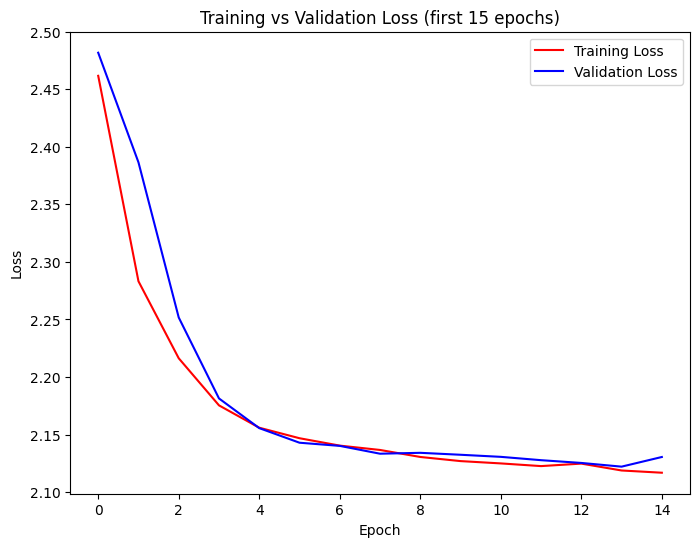

In [39]:
# In your "Now Visualize losses" cell
import matplotlib.pyplot as plt
N = min(15, len(train_losses))
epochs = range(N)
plt.figure(figsize=(8,6))
plt.plot(epochs, train_losses[:N], label='Training Loss', color='red')
plt.plot(epochs, val_losses[:N],   label='Validation Loss', color='blue')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss (first 15 epochs)')
plt.legend(); plt.show()


### Prediction Visualisation

Display several images, their masks, and the predicted mask by your model.

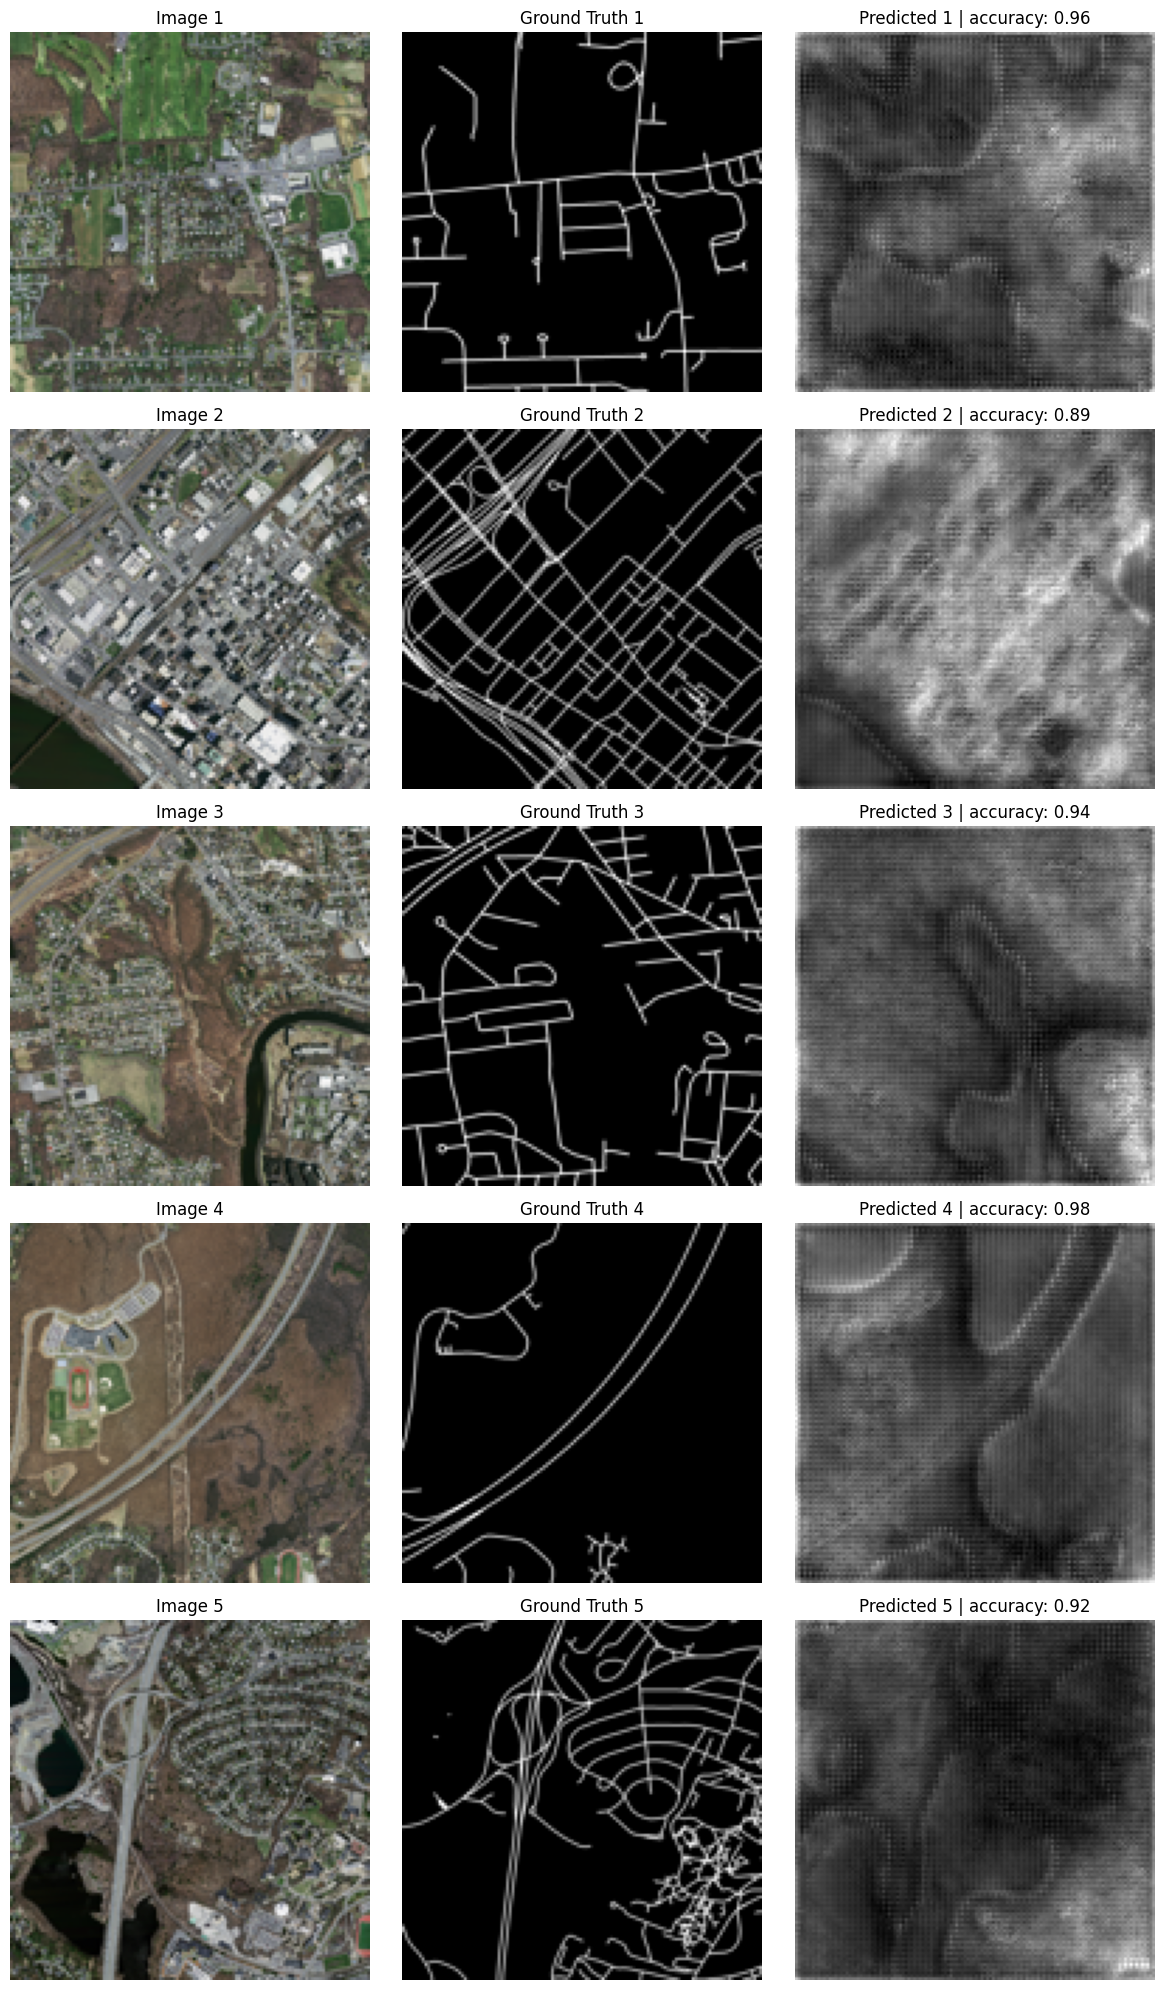

In [51]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_image_mask_prediction(images, masks, predictions, n=5):
    """
    Show n rows: [Image | Ground Truth | Predicted] with a simple pixel accuracy.
    Accepts numpy arrays or torch tensors; handles (H,W,C) / (C,H,W) and mask channel dims.
    """
    max_n = min(n, len(images), len(masks), len(predictions))
    plt.figure(figsize=(12, 4 * max_n))

    for i in range(max_n):
        img = images[i]
        gt  = masks[i]
        pr  = predictions[i]

        if torch.is_tensor(img): img = img.detach().cpu().numpy()
        if torch.is_tensor(gt):  gt  = gt.detach().cpu().numpy()
        if torch.is_tensor(pr):  pr  = pr.detach().cpu().numpy()

        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = np.transpose(img, (1, 2, 0))
        if gt.ndim  == 3: gt  = np.squeeze(gt)
        if pr.ndim  == 3: pr  = np.squeeze(pr)

        img = np.clip(img, 0, 1)
        gt  = np.clip(gt,  0, 1)
        pr  = np.clip(pr,  0, 1)

        acc = float(((pr > 0.5) == (gt > 0.5)).mean())

        plt.subplot(max_n, 3, 3*i + 1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis("off")

        plt.subplot(max_n, 3, 3*i + 2)
        plt.imshow(gt, cmap="gray")
        plt.title(f"Ground Truth {i+1}")
        plt.axis("off")

        plt.subplot(max_n, 3, 3*i + 3)
        plt.imshow(pr, cmap="gray")
        plt.title(f"Predicted {i+1} | accuracy: {acc:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

n = 5
imgs_np  = val_images[:n]
masks_np = val_masks[:n]

imgs_t = torch.from_numpy(imgs_np).permute(0, 3, 1, 2).float().to(device)

if masks_np.ndim == 3:
    masks_t = torch.from_numpy(masks_np[:, None, ...]).float().to(device)
elif masks_np.ndim == 4 and masks_np.shape[-1] == 1:
    masks_t = torch.from_numpy(np.transpose(masks_np, (0, 3, 1, 2))).float().to(device)
else:
    masks_t = torch.from_numpy(masks_np).float().to(device)

model = unet
model.eval()
with torch.no_grad():
    preds_t = model(imgs_t)
preds_np = preds_t.cpu().numpy().squeeze(1)

visualize_image_mask_prediction(imgs_np, masks_np, preds_np, n=n)
